### Phát biểu của SVD :
Một ma trận A(m x n) bất kỳ đểu có thể phân tính thành :

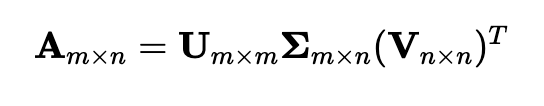

Trong đó U và V là các ma trận trực giao . M là ma trận đường chéo không vuông .. Số lượng các phần tử khác 0 của nó ở đường chéo( chỉ số hàng bằng cột) là rank của ma trận.

Việc chứng minh sự tồn tại của SVD tại đây : http://db.cs.duke.edu/courses/cps111/spring07/notes/12.pdf


In [ ]:
# Import libraries
import numpy as np
import pandas as pd

# Reading ratings file
ratings = pd.read_csv('ratings.csv', sep='\t', encoding='latin-1', usecols=['user_id', 'movie_id', 'rating', 'timestamp'])

# Reading users file
users = pd.read_csv('users.csv', sep='\t', encoding='latin-1', usecols=['user_id', 'gender', 'zipcode', 'age_desc', 'occ_desc'])

# Reading movies file
movies = pd.read_csv('movies.csv', sep='\t', encoding='latin-1', usecols=['movie_id', 'title', 'genres'])

print('minh dan')

In [ ]:
# Kiểm tra dữ liệu 
movies.head()

In [ ]:
ratings.head()


In [ ]:
# Lấy số lượng user , movies bằng ratings 
n_users = ratings.user_id.unique().shape[0]
n_movies = ratings.movie_id.unique().shape[0]
print('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_movies))

In [ ]:
# Định dạng lại ratings matrix 
Ratings = ratings.pivot(index = 'user_id', columns ='movie_id', values = 'rating').fillna(0)
Ratings.head()
# Qua hình ta thấy được độ thưa thớt của ma trận ...

In [ ]:
# chuyen hoa sang numpy
R = Ratings.to_numpy()
user_ratings_mean = np.mean(R, axis = 1)
Ratings_demeaned = R - user_ratings_mean.reshape(-1, 1)

## Model-Based Collaborative Filtering

Khi ta có một ma trận với kích thước rất lớn . Bằng việc phân tích ma trận Ta có thể cấu trúc lại User-Item Matrix về dạng ma trận nhỏ hơn .

Bằng phép nhân ma trận có hạng nhỏ hơn sẽ tìm ra được các điểm còn thiếu trong ma trận ban đầu.



### Setting up SVD 
Scipy và Numpy đều có các chức năng thực hiện việc phân hủy giá trị đơn lẻ. Tôi sẽ sử dụng hàm Scipy *svds* vì nó cho phép tôi chọn số lượng hệ số tiềm ẩn mà tôi muốn sử dụng để ước lượng ma trận xếp hạng ban đầu (thay vì phải cắt bớt sau đó).

In [ ]:
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(Ratings_demeaned, k = 50)


Tận dụng phép nhân ma trận để dự đoán vì thế t chuyển $\Sigma$ sang dạng ma trận đường chéo .


In [ ]:
sigma = np.diag(sigma)

### Making Predictions from the Decomposed Matrices


In [ ]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)


Với ma trận dự đoán của người dùng tôi có thể gợi ý cho tất cả mọi người danh sách phim họ có thể yêu thích.

In [ ]:
preds = pd.DataFrame(all_user_predicted_ratings, columns = Ratings.columns)
preds.head()

Bây giờ tôi viết một hàm để trả về những bộ phim có xếp hạng dự đoán cao 
nhất mà người dùng được chỉ định chưa xếp hạng.

In [ ]:
def recommend_movies(predictions, userID, movies, original_ratings, num_recommendations):
    
    # Get and sort the user's predictions
    user_row_number = userID - 1 # User ID starts at 1, not 0
    sorted_user_predictions = preds.iloc[user_row_number].sort_values(ascending=False) # User ID starts at 1
    
    # Get the user's data and merge in the movie information.
    user_data = original_ratings[original_ratings.user_id == (userID)]
    user_full = (user_data.merge(movies, how = 'left', left_on = 'movie_id', right_on = 'movie_id').
                     sort_values(['rating'], ascending=False)
                 )

    print('User {0} has already rated {1} movies.'.format(userID, user_full.shape[0]))
    print('Recommending highest {} predicted ratings movies not already rated.'.format(num_recommendations))
    
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (movies[~movies['movie_id'].isin(user_full['movie_id'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'movie_id',
               right_on = 'movie_id').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    return user_full, recommendations

 Hãy thử gợi ý cho 10 bộ phim cho User có  ID 1000
    

In [ ]:
already_rated, predictions = recommend_movies(preds, 1000, movies, ratings, 10)

In [ ]:
# Phim đã rated
already_rated.head(20)

In [ ]:
# Gợi ý 
predictions

Có vể đây là một kết quả gợi ý khá tốt . Mặc dù tôi ko dùng các nội dung của phim - Tuy nhiên tôi cũng đưa ra được 
các dự đáon các bộ phim có thể loại Action , Drama , Animation mà người dùng yêu thích .

### Model Evalutaion


Tôi sẽ sử dụng *[Surprise](https://pypi.python.org/pypi/scikit-surprise)* thư viện cung cấp sẵn các thuật toán mạnh mẽ (SVD) để đánh giá trên tập dữ liệu MovieLens .


In [ ]:
# Import libraries from Surprise package
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

# Load Reader library
reader = Reader()

# Load ratings dataset with Dataset library
data = Dataset.load_from_df(ratings[['user_id', 'movie_id', 'rating']], reader)

# Split the dataset for 5-fold evaluation
#data.split(n_folds=5)

# Use the SVD algorithm.
svd = SVD()

print('nguyen minh dan')
# Compute the RMSE of the SVD algorithm.
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

